## Using dask for EODC items

In this notebook we are going to take a look at stac items we retrieved from EODC and try to adapt some dask worklow to it. The two cores of the dask library we are going to use are parallel processing and lazy loading. These two functions tie smoothly into our workflow because they allow us to keep working with stac items and their quality of just being mata data. That means that we can create a nice worklow without actually downloading any real data into our local RAM or memory. 

In [62]:
#These are the important packages we first need to import 

import os
import json
from datetime import datetime
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import pystac
from pystac_client import Client
from odc import stac as odc_stac
from odc.geo.geobox import GeoBox
from affine import Affine
import sys

import dask.dataframe as dd
import dask.array as da

In [63]:
#The code here adjusts the width of the nootebook display container

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Get stac items from EODC catalogue

In [64]:
#This is how we access the AI4SAR collection via the stac_api

stac_api = "https://stac.eodc.eu/api/v1"
client = Client.open(stac_api)

collection_id="AI4SAR_SIG0"

In [65]:
#Next we search for certain items in the AI4SAR_SIG0 collection, defining the area and time period
collection_id="AI4SAR_SIG0"

bbox = [15.6, 47.7, 16.6, 48.7]  # [lon_min, lat_min, lon_max, lat_max]
start_date = "2023-01-01"
end_date = "2023-10-31"

query = client.search(bbox=bbox,
                        collections=[collection_id],
                        datetime=f"{start_date}/{end_date}",
                        )
q_items = sorted(query.items(), key=lambda x: x.id)

In [66]:
for item in q_items:
    print(item)

print("\n","The length of the list of items is",len(q_items))



<Item id=SIG0_20230418T050210_D124_EU020M_E051N015T3_S1AIWGRDH>
<Item id=SIG0_20230512T050211_D124_EU020M_E051N015T3_S1AIWGRDH>
<Item id=SIG0_20230617T050213_D124_EU020M_E051N015T3_S1AIWGRDH>

 The length of the list of items is 3


In [67]:
#Here we take a look at the metadata of one item.

q_items[0].properties

{'gsd': 20,
 'datetime': '2023-04-18T05:02:10Z',
 'proj:bbox': [5100000, 1500000, 5400000, 1800000],
 'proj:wkt2': 'PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]',
 'proj:shape': [15000, 15000],
 'constellation': 'sentinel-1',
 'proj:geometry': {'type': 'Polygon',
  'coordinates': [[[5100000.0, 1500000.0],
    [5100000.0, 1800000.0],
    [5400000.0, 1800000.0],
    [5400000.0, 1500000.0],
    [5100000.0, 1500000.0]]]},
 'proj:transform': [20, 0, 5100000, 0, -20, 1800000],
 'sat:orbit_state': 'descending',
 'sar:product_type': 'GRD',
 'sar:frequency_band': 'C',
 'sat:rel

## Get dask started

First it all starts with creating and connecting to a client which helps us to submit tasks, monitor processes and retrieve results. The neat thing is that our client could be connected to any scale of computational power. We could either connect it with our local pc, a high performance computer (HPC) or a cloud optimized platform. For now we are going to connect our client with our local pc or so called local cluster.

In [68]:
# Let's start simple with a LocalCluster that makes use of all the cores and RAM we have on a single machine
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
# explicitly connect to the cluster we just created
client = Client(cluster)
client


/home/jlinke/miniconda3/envs/EODC/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40891 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40891/status,
Dashboard: http://127.0.0.1:40891/status,Workers: 4
Total threads: 16,Total memory: 31.24 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35311,Workers: 4
Dashboard: http://127.0.0.1:40891/status,Total threads: 16
Started: Just now,Total memory: 31.24 GiB
Comm: tcp://127.0.0.1:38085,Total threads: 4
Dashboard: http://127.0.0.1:33933/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:41119,


If we look at the cluster info there are several important keywords for us to understand. Like for example workers which are responsible for executing the actual computations. They fetch tasks from the scheduler, process the tasks, and then return the results. By default, Dask often configures one worker per CPU core, but this can be adjusted. Threads are smaller units of processing that run within workers, enabling parallel execution within the same worker process. Workers operate as independent processes, each with their own memory space, while threads share the same memory space within a worker, allowing for efficient data sharing and concurrent execution.

## Xarray vs. dask array



In order to create a worklow with our new local dask cluster we are getting back to our stac items and look at  two possibilites of storing the items in our RAM either as xarray or dask array.


In [69]:
bands = ("VV", "VH")
crs = "EPSG:4326"
bbox = [15.6, 47.7, 16.6, 48.7]
res = 0.00018 # 20 meter in degree
sig0_ds = odc_stac.stac_load(q_items,
                        bands=bands,
                        crs=crs,
                        resolution=res,
                        bbox=bbox,
                        use_overviews=False,
                        )

The quality of an xarray is a very flexible overview and workflow with many kinds of dimensions. In this case the dimensions we get from our items are latitude, longitude and time plus two data variables VV and VH polarisation which could also be seen as another two dimensions. Working with an xarray we can easily retrieve the data with need as new array and do array based computations. The drawback is that we are limited when it comes to computational power. 

In [70]:
#Looking at the Xarray
sig0_ds

<xarray.Dataset> Size: 371MB
Dimensions:      (latitude: 5556, longitude: 5557, time: 3)
Coordinates:
  * latitude     (latitude) float64 44kB 48.7 48.7 48.7 48.7 ... 47.7 47.7 47.7
  * longitude    (longitude) float64 44kB 15.6 15.6 15.6 15.6 ... 16.6 16.6 16.6
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 24B 2023-04-18T05:02:10 ... 2023-06-17...
Data variables:
    VV           (time, latitude, longitude) int16 185MB -9999 -9999 ... -97 -97
    VH           (time, latitude, longitude) int16 185MB -9999 -9999 ... -165

Compared to an xarray a dask array is not that handy when it comes to handling dimensions. We have to give it a little more thought and look at how we could put the xarray in so called chunks...

The real quality of a dask array is about optimizing computations... 

In [85]:
sig0_ds_chunked1=sig0_ds.chunk({'latitude': 5556,'longitude': 5557,'time': 1})

sig0_VV_da1 = sig0_ds_chunked1['VV'].data
sig0_VH_da1 = sig0_ds_chunked1['VH'].data

display(sig0_VV_da1)
display(sig0_VH_da1)

dask.array<xarray-VV, shape=(3, 5556, 5557), dtype=int16, chunksize=(1, 5556, 5557), chunktype=numpy.ndarray>

dask.array<xarray-VH, shape=(3, 5556, 5557), dtype=int16, chunksize=(1, 5556, 5557), chunktype=numpy.ndarray>

In [84]:
sig0_ds_chunked2=sig0_ds.chunk({'latitude':1000,'longitude':1000,'time':1})

sig0_VV_da2=sig0_ds_chunked2['VV'].data
sig0_VH_da2=sig0_ds_chunked2['VH'].data


display(sig0_VV_da2)
display(sig0_VH_da2)



dask.array<xarray-VH, shape=(3, 5556, 5557), dtype=int16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>

dask.array<xarray-VH, shape=(3, 5556, 5557), dtype=int16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>

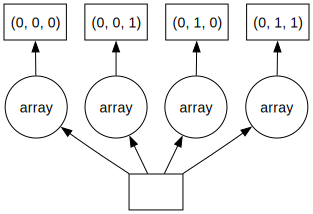

In [ ]:
sig0_da.visualize(format='svg')